In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import Dataset
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
class ShipDetectionDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, grid_size=8, num_boxes=1):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.grid_size = grid_size
        self.num_boxes = num_boxes
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))
        
        img = Image.open(img_path).convert("RGB")
        width, height = img.size
        
        # Transform image
        if self.transform:
            img = self.transform(img)
        
        # Prepare target grid - keep as flat for now (will reshape in loss function)
        target = torch.zeros((self.grid_size, self.grid_size, self.num_boxes * 5))

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    cx, cy, w, h = map(float, parts[1:])

                    # which grid cell
                    grid_x = int(cx * self.grid_size)
                    grid_y = int(cy * self.grid_size)

                    if grid_x >= self.grid_size: grid_x = self.grid_size - 1
                    if grid_y >= self.grid_size: grid_y = self.grid_size - 1

                    # relative to cell
                    cell_cx = cx * self.grid_size - grid_x
                    cell_cy = cy * self.grid_size - grid_y
                    cell_w = w * self.grid_size
                    cell_h = h * self.grid_size

                    # find an empty box slot (objectness == 0)
                    for b in range(self.num_boxes):
                        if target[grid_y, grid_x, b*5 + 4] == 0:
                            target[grid_y, grid_x, b*5 + 0] = cell_cx
                            target[grid_y, grid_x, b*5 + 1] = cell_cy
                            target[grid_y, grid_x, b*5 + 2] = cell_w
                            target[grid_y, grid_x, b*5 + 3] = cell_h
                            target[grid_y, grid_x, b*5 + 4] = 1  # objectness
                            break
        
        return img, target

In [4]:
class ShipDetectorYOLO(nn.Module):
    def __init__(self, grid_size=8, num_boxes=1):
        super(ShipDetectorYOLO, self).__init__()
        self.grid_size = grid_size
        self.num_boxes = num_boxes
        self.output_size = num_boxes * 5  # (x, y, w, h, obj)

        # Calculate needed output size to get grid_size after feature extraction
        self.target_feature_size = grid_size
        
        # Modified architecture to ensure proper output size
        self.features = nn.Sequential(
            # Input is typically 256x256 from the transform
            # Need to go from 256x256 -> 8x8 feature map
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 256 -> 256
            nn.ReLU(),
            nn.MaxPool2d(2),  # 256 -> 128
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 128 -> 128
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64 -> 64
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 32 -> 32
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16
            
            # Add one more pooling to get to 8x8
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 16 -> 16
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8
        )

        self.prediction_head = nn.Conv2d(128, self.output_size, kernel_size=1)

    def forward(self, x):
        x = self.features(x)
        # Print feature map shape to confirm it's 8x8
        print(f"Feature map shape: {x.shape}")
        x = self.prediction_head(x)
        x = x.permute(0, 2, 3, 1)  # (batch, grid, grid, output_size)
        return x

In [5]:
# Fixed loss function
def yolo_loss(predictions, targets, num_boxes=1):
    # Get shapes
    batch_size = predictions.shape[0]
    pred_grid_size = predictions.shape[1]
    target_grid_size = targets.shape[1]
    
    print(f"Predictions shape: {predictions.shape}")
    print(f"Targets shape: {targets.shape}")
    
    # Check if shapes match
    if pred_grid_size != target_grid_size:
        raise ValueError(f"Grid size mismatch: predictions {pred_grid_size}x{pred_grid_size}, targets {target_grid_size}x{target_grid_size}")
    
    # Reshape predictions to separate box params
    predictions = predictions.reshape(batch_size, pred_grid_size, pred_grid_size, num_boxes, 5)
    
    # Reshape targets if needed
    if targets.shape[3] == num_boxes * 5:
        targets = targets.reshape(batch_size, target_grid_size, target_grid_size, num_boxes, 5)
    
    print(f"Reshaped predictions: {predictions.shape}")
    print(f"Reshaped targets: {targets.shape}")

    # Create masks for objects
    obj_mask = targets[..., 4] > 0
    noobj_mask = targets[..., 4] == 0

    # Coordinate loss (only for cells with objects)
    coord_loss = F.mse_loss(
        predictions[..., 0:2][obj_mask], 
        targets[..., 0:2][obj_mask], 
        reduction='sum'
    )
    
    # Size loss (only for cells with objects)
    size_loss = F.mse_loss(
        predictions[..., 2:4][obj_mask], 
        targets[..., 2:4][obj_mask], 
        reduction='sum'
    )
    
    # Objectness loss
    obj_loss = F.mse_loss(
        predictions[..., 4][obj_mask], 
        targets[..., 4][obj_mask], 
        reduction='sum'
    )
    
    noobj_loss = F.mse_loss(
        predictions[..., 4][noobj_mask], 
        targets[..., 4][noobj_mask], 
        reduction='sum'
    )
    
    # Normalize by number of objects (add small epsilon to avoid division by zero)
    total_obj = obj_mask.float().sum() + 1e-6
    
    # Weight the losses
    coord_weight = 5.0
    noobj_weight = 0.5
    
    total_loss = (coord_weight * coord_loss + size_loss + obj_loss + noobj_weight * noobj_loss) / total_obj
    
    return total_loss

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Set directories 
images_dir = './ship_dataset_v0/'
labels_dir = './ship_dataset_v0/'

grid_size = 8
num_boxes = 1

# Dataset and DataLoader
train_dataset = ShipDetectionDataset(
    images_dir=images_dir, 
    labels_dir=labels_dir, 
    transform=transform, 
    grid_size=grid_size, 
    num_boxes=num_boxes
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Model and optimizer
model = ShipDetectorYOLO(grid_size=grid_size, num_boxes=num_boxes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [7]:
# print(f"Using device: {device}")

# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
    
#     for batch_idx, (images, targets) in enumerate(train_loader):
#         images = images.to(device)
#         targets = targets.to(device)
        
#         # Forward pass
#         predictions = model(images)
        
#         # Calculate loss
#         try:
#             loss = yolo_loss(predictions, targets, num_boxes=num_boxes)
            
#             # Backward pass and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()
            
#             if batch_idx % 10 == 0:
#                 print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
                
#         except Exception as e:
#             print(f"Error during training: {e}")
#             continue
    
#     epoch_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0
#     print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

# # Save the model
# torch.save(model.state_dict(), 'ship_detector_model.pth')
# print("Training completed and model saved!")


In [8]:
def detect_ships(model, image_path, transform, device, grid_size=8, num_boxes=1, confidence_threshold=0.5):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        predictions = model(img_tensor)
        predictions = predictions.reshape(1, grid_size, grid_size, num_boxes, 5)
        
    # Get all cells with objectness > threshold
    obj_cells = predictions[0, :, :, :, 4] > confidence_threshold
    
    detections = []
    for grid_y in range(grid_size):
        for grid_x in range(grid_size):
            for b in range(num_boxes):
                if predictions[0, grid_y, grid_x, b, 4] > confidence_threshold:
                    # Extract box parameters
                    cx = (predictions[0, grid_y, grid_x, b, 0] + grid_x) / grid_size
                    cy = (predictions[0, grid_y, grid_x, b, 1] + grid_y) / grid_size
                    w = predictions[0, grid_y, grid_x, b, 2] / grid_size
                    h = predictions[0, grid_y, grid_x, b, 3] / grid_size
                    confidence = predictions[0, grid_y, grid_x, b, 4].item()
                    
                    # Convert to absolute coordinates
                    img_w, img_h = img.size
                    box_x1 = max(0, (cx - w/2) * img_w)
                    box_y1 = max(0, (cy - h/2) * img_h)
                    box_x2 = min(img_w, (cx + w/2) * img_w)
                    box_y2 = min(img_h, (cy + h/2) * img_h)
                    
                    detections.append({
                        'box': [box_x1, box_y1, box_x2, box_y2],
                        'confidence': confidence
                    })
                    
    return detections, img

Feature map shape: torch.Size([1, 128, 8, 8])
Found 3 ships:
Ship 1: Box coordinates: [tensor(102.5787), tensor(130.0256), tensor(125.8117), tensor(151.4918)], Confidence: 0.82
Ship 2: Box coordinates: [tensor(6.3455), tensor(170.5543), tensor(30.5412), tensor(187.6161)], Confidence: 0.98
Ship 3: Box coordinates: [tensor(51.1813), tensor(181.2016), tensor(75.9790), tensor(196.0392)], Confidence: 1.06


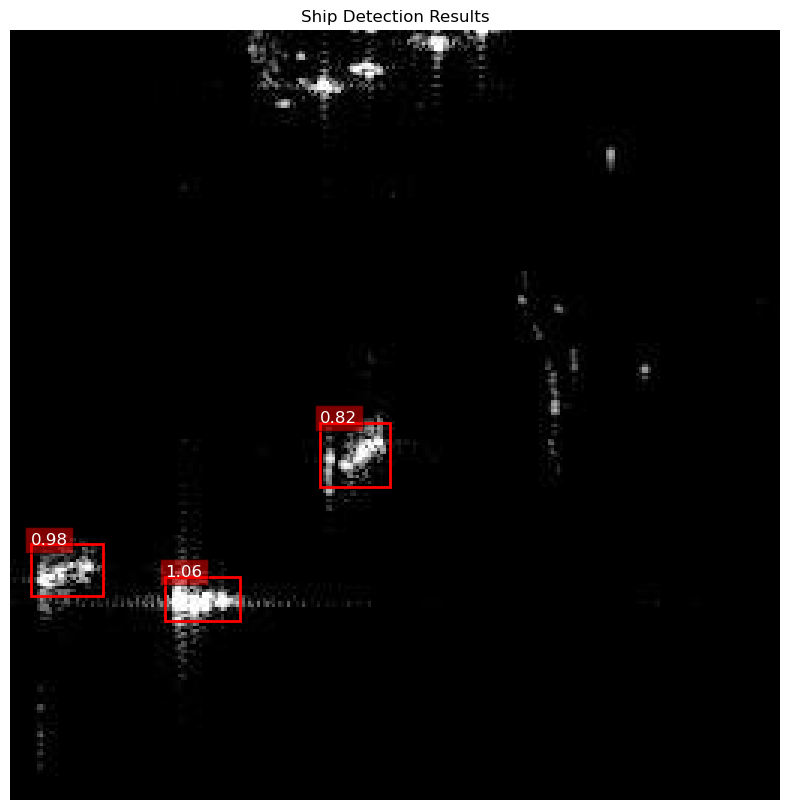

In [11]:
# Load your trained model
model = ShipDetectorYOLO(grid_size=8, num_boxes=1).to(device)
model.load_state_dict(torch.load('ship_detector_model.pth', map_location=device))
model.eval()

# Path to your test image
test_image_path = './testing/testing2.jpg'  # Change this to your test image path

# Detect ships in the image
detections, original_image = detect_ships(
    model=model,
    image_path=test_image_path,
    transform=transform,  # Use the same transform you defined for training
    device=device,
    grid_size=8,
    num_boxes=1,
    confidence_threshold=0.5  # Adjust this threshold as needed
)

# Print the detected ships
print(f"Found {len(detections)} ships:")
for i, det in enumerate(detections):
    print(f"Ship {i+1}: Box coordinates: {det['box']}, Confidence: {det['confidence']:.2f}")

# Visualize the detections
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(10, 10))
plt.imshow(original_image)
ax = plt.gca()

# Draw bounding boxes
for det in detections:
    x1, y1, x2, y2 = det['box']
    width = x2 - x1
    height = y2 - y1
    
    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    # Add confidence score label
    plt.text(x1, y1, f"{det['confidence']:.2f}", color='white', fontsize=12,
             bbox=dict(facecolor='red', alpha=0.5))

plt.title('Ship Detection Results')
plt.axis('off')
plt.savefig('detection_result.png')
plt.show()